# IUCN Red List Data

Our main data source is the International Union For Conservation of Nature (IUCN). This is an international organization working on the field of nature conservation. They provide the most relevant and detaild data on threatened and extinct species.

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from countries import get_country_list, get_for_IUCN

## Getting the Data

We encountered several problems for utilizing the data provided by the IUCN.

### Dificulties

First, summery statistics. The provided data is often times in a format that is not machine readable (PDFs) or when machine readable files (CSVs) are available the data is not provided in sufficent detail per country. 
Second, spatial data. This type of data provides detaild information per group of species. The data is provided as polygons but as our goal is to compare different characteristics of countries we would have to map the polygons to countries which is not a trivial task as the IUCNs process to define which species is resident in which country is very sophisticated and not easy to reproduce.
Third, there is no "historical" data on threatened species. Only some PDFs document the changes in status per species and year but the IUCN specifically states that "This table (Table 7) should not be used to calculate a Red List Index (RLI); for this it is necessary to analyse the underlying Red List data to identify genuine status changes between specific years for specific taxonomic groups."

### Solution

The approach we therefore took was to scrape the needed data from the IUCN webpage using the advanced search at: https://www.iucnredlist.org/search

We approached getting the data by using **selenium** and **beautifulsoup4** as they let us navigate the IUCN Webpage and extract the species on a per country level.

### ToDo: 
- explain scraping process

## Load Raw Data

In this step we load the raw scraped data as provided on the IUCN webpage.

### ToDo:
- describe and comment

In [2]:
def load_IUCN_data():
    all_countries = []
    DATA_PATH = Path('./data/IUCN/scraped/')
    file_paths = DATA_PATH.glob('*.csv')

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['country'] = file_path.stem
        all_countries.append(df)
    return pd.concat(all_countries, ignore_index=True)
IUCN_raw_data = load_IUCN_data()

In [3]:
IUCN_raw_data.shape

(136624, 7)

In [4]:
IUCN_raw_data.head()

,kingdom_class,common_name,scientific_name,trend,region,threat_level,country
0,animalia — mammalia,NaN,Molossus molossus,Unknown,Global,Least Concern,Argentina
1,animalia — mammalia,Monito del Monte,Dromiciops gliroides,Decreasing,Global,Near Threatened,Argentina
2,animalia — mammalia,Chacoan Naked-tailed Armadillo,Cabassous chacoensis,Unknown,Global,Near Threatened,Argentina
3,animalia — mammalia,Greater Naked-tailed Armadillo,Cabassous tatouay,Unknown,Global,Least Concern,Argentina
4,animalia — mammalia,Southern Three-banded Armadillo,Tolypeutes matacus,Decreasing,Global,Near Threatened,Argentina


## Problems in dataset

In [5]:
IUCN_raw_data.isna().sum()

kingdom_class          0
common_name        43403
scientific_name        0
trend               2986
region                 0
threat_level           0
country                0
dtype: int64

In [6]:
# kingdom the same as we only read animals
# scientific class names not human readable and include sea animals
IUCN_raw_data['kingdom_class'].unique()

array(['animalia — mammalia', 'animalia — actinopterygii',
       'animalia — insecta', 'animalia — reptilia', 'animalia — amphibia',
       'animalia — aves', 'animalia — chondrichthyes',
       'animalia — cephalaspidomorphi', 'animalia — malacostraca',
       'animalia — cephalopoda', 'animalia — gastropoda',
       'animalia — bivalvia', 'animalia — arachnida', 'animalia — myxini',
       'animalia — holothuroidea', 'animalia — anthozoa',
       'animalia — hydrozoa', 'animalia — branchiopoda',
       'animalia — maxillopoda', 'animalia — sarcopterygii',
       'animalia — ostracoda', 'animalia — onychophora',
       'animalia — clitellata', 'animalia — enopla',
       'animalia — turbellaria', 'animalia — echinoidea',
       'animalia — asteroidea', 'animalia — merostomata',
       'animalia — polychaeta', 'animalia — monoplacophora',
       'animalia — diplopoda', 'animalia — entognatha'], dtype=object)

In [7]:
# not sure how to use region
IUCN_raw_data['region'].unique()

array(['Global', 'Global, Caribbean', 'Global, Mediterranean',
       'Global, Europe', 'Global, Europe, Mediterranean',
       'Global, Arabian Sea', 'Global, Northern Africa, Pan-Africa',
       'Global, Caribbean, Gulf of Mexico', 'Global, Gulf of Mexico',
       'Global, Persian Gulf', 'Global, Pan-Africa',
       'Global, Pan-Africa, S. Africa FW',
       'Global, Eastern Africa, Pan-Africa'], dtype=object)

In [8]:
# missing data on web search "[missing "en.shared.categories.cd" translation]"
IUCN_raw_data.threat_level.unique()

array(['Least Concern', 'Near Threatened', 'Vulnerable', 'Endangered',
       'Critically Endangered', 'Data Deficient', 'Extinct in the Wild',
       'Extinct', '[missing "en.shared.categories.cd" translation]'],
      dtype=object)

## Preparing the data

For the threat_level some datapoints are missing. We checked the species directly on the webpage.
There is no value for is and so and we use 'Data Deficient' for these.

### Translate classes of animals
From Wikipedia as nothing found on IUCN

- mammalia: Mammals
- actinopterygii: Ray-finned fishes
- insecta: Insects
- amphibia: Amphibians
- aves: Birds
- bivalvia: clams, oysters, cockles, mussels, scallops
- gastropoda: Snails and Slugs (could also be located in the sea)
- cephalaspidomorphi: jawless fishes
- clitellata: Worms
- reptilia: Reptiles
- chondrichthyes: cartilaginous fishes
- malacostraca: crustaceans
- hydrozoa: individually very small, predatory animals, most living in salt water
- turbellaria: flatworms

call class -> group as it could lead to problems with name class in python

### Todo
- describe and comment

In [9]:
def clean_data(data, filter_terrestrial=True):
    # remove column common name and region
    data = data.drop(columns=['common_name', 'region'])

    # categorize missing scraped data for trend to existing Data Deficient category
    data.threat_level.replace({
        '[missing "en.shared.categories.cd" translation]': 'Data Deficient'},
        inplace=True)

    # fill nan vlaues in trend with existing Unknown category
    data.trend.fillna('Unknown', inplace=True)

    # extract only class as kingdom is always animalia
    data['kingdom_class'] = data.apply(lambda row: row['kingdom_class'].split()[-1], axis=1)
    data = data.rename(columns={'kingdom_class': 'group'})

    # only select none sea animals
    if filter_terrestrial:
        none_sea_animals = ['mammalia', 'insecta', 'amphibia', 'aves', 'reptilia'] # todo: decide if to use Worms ('clitellata')
        data = data[data.group.isin(none_sea_animals)]

    # rename classes 
    data.group.replace({
        'mammalia': 'mammals',
        'insecta': 'insects',
        'amphibia': 'amphibians',
        'aves': 'birds',
        'clitellata': 'worms',
        'reptilia': 'reptiles',
        },
        inplace=True)

    # rename threat levels 
    data.threat_level.replace({
        'Extinct': 'EX',
        'Extinct in the Wild': 'EW',
        'Critically Endangered': 'CR',
        'Endangered': 'EN',
        'Vulnerable': 'VU',
        'Near Threatened': 'NT',
        'Least Concern': 'LC',
        'Data Deficient': 'DD',
        },
        inplace=True)

    return data
IUCN_cleaned_data = clean_data(IUCN_raw_data)

In [10]:
IUCN_cleaned_data.shape

(66669, 5)

In [11]:
IUCN_cleaned_data.head()

,group,scientific_name,trend,threat_level,country
0,mammals,Molossus molossus,Unknown,LC,Argentina
1,mammals,Dromiciops gliroides,Decreasing,NT,Argentina
2,mammals,Cabassous chacoensis,Unknown,NT,Argentina
3,mammals,Cabassous tatouay,Unknown,LC,Argentina
4,mammals,Tolypeutes matacus,Decreasing,NT,Argentina


## Check if scraped data is complete

For this we use Table 6a of the IUCN Summary Statistics

IUCN Red List Categories: EX - Extinct, EW - Extinct in the Wild, CR - Critically Endangered (includes CR(PE) and CR(PEW)), EN - Endangered, VU - Vulnerable, LR/cd - Lower Risk/conservation dependent, NT - Near Threatened (includes LR/nt - Lower Risk/near threatened), DD - Data Deficient, LC - Least Concern (includes LR/lc - Lower Risk/least concern).

CR(PE) & CR(PEW): The tags 'Possibly Extinct' and 'Possibly Extinct in the Wild' have been developed to identify CR species that are likely already extinct (or extinct in the wild), but require more investigation to confirm this. NOTE that these are not IUCN Red List Categories; they are tags that can be attached to the CR category to highlight those taxa that are possibly extinct. They are included in the above table to indicate a plausible upper estimate for number of recently extinct species on The IUCN Red List.

In [12]:
# Bring Data In same format as Table 6a
IUCN_cleaned_all = clean_data(IUCN_raw_data, filter_terrestrial=False)
grouped = IUCN_cleaned_all.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl = grouped.pivot_table(index='country', columns='threat_level', values='count')
species_tl = species_tl.fillna(0.0)
species_tl['Total'] = species_tl.sum(axis=1)
species_tl = species_tl.convert_dtypes(convert_integer=True)
species_tl.head()

,CR,DD,EN,EW,EX,LC,NT,VU,Total
country,,,,,,,,,
Argentina,40,178,69,3,3,2210,127,118,2748
Armenia,7,18,8,0,0,471,38,26,568
Australia,137,664,255,0,42,5867,442,613,8020
Austria,24,66,29,0,3,851,81,52,1106
Azerbaijan,13,45,10,1,0,583,41,31,724


In [13]:
def load_table6a(threat_levels, country_rename_mapper, country_list):
    # load data
    DATA_PATH = Path('./data/IUCN')
    data = pd.read_csv(DATA_PATH / 'Table 6a Animal species (kingdom Animalia) by country - show all.csv', thousands=',')
    # rename columns
    data = data.rename(columns={
        'Name': 'country',
        'NT or LR/nt': 'NT',
        'LC or LR/lc': 'LC',
    })
    # todo: add LR/cd (Lower Risk/conservation dependent) to NT or LC
    data['LC'] = data['LC'] + data['LR/cd']
    # only select needed threat_levels
    data = data[['country'] + threat_levels]
    # rename countrys
    data.country.replace(country_rename_mapper, inplace=True)
    # only select needed countrys
    data = data[data.country.isin(country_list)]
    data = data.sort_values('country')
    data = data.set_index('country')

    return data

threat_levels = list(species_tl.columns)
country_dict = get_for_IUCN()
country_rename_mapper = {d['country_iucn']: d['country_name'] for d in country_dict}
country_list = get_country_list()
table6a = load_table6a(threat_levels, country_rename_mapper, country_list)
assert len(country_list) == table6a.shape[0]

In [14]:
species_tl_total = species_tl[['Total']].rename(columns={'Total': 'Total_scraped'})
species_tl_total = species_tl_total.reset_index()
evaluate_difference = table6a.merge(species_tl_total, how='left', on='country').set_index('country')
evaluate_difference['diff'] = evaluate_difference['Total'] - evaluate_difference['Total_scraped']
evaluate_difference[evaluate_difference['diff'] != 0]

,CR,DD,EN,EW,EX,LC,NT,VU,Total,Total_scraped,diff
country,,,,,,,,,,,
Argentina,41,178,69,3,3,2211,127,118,2750,2748,2
Australia,138,661,255,0,42,5871,442,613,8022,8020,2
Brazil,105,700,144,2,11,4777,230,287,6256,6249,7
Canada,18,87,32,0,9,1902,64,84,2196,2195,1
Chile,25,201,62,0,1,1302,84,81,1756,1754,2
Colombia,126,586,227,0,1,5285,259,361,6845,6840,5
Costa Rica,35,235,82,0,4,3392,107,154,4009,4008,1
Greenland,2,20,5,0,1,217,8,20,273,272,1
India,94,868,230,0,0,4334,331,398,6255,6253,2


In [15]:
# how can this be explaned ? do I need to calculate something differen for some categorys?
# how to explain this difference in scraped data and data in the table ? data on probaply newer than summary statistics

## Create relative numbers per group

As we want to know the Relative numbers of species in each group we transform our current data.

Threatened species are listed in any of the three categories Critically Endangered (CR), Endangered (EN) or Vulnerable (VU).

*Reptiles, fishes, molluscs, other invertebrates, plants, fungi and chromists: please note that for these groups, there are still many species that have not yet been assessed for the IUCN Red List and therefore their status is not known (i.e., these groups have not yet been completely assessed). Therefore the figures presented below for these groups should be interpreted as the number of species known to be threatened within those species that have been assessed to date, and not as the overall total number of threatened species for each group.

In [16]:
def threatened_by_group(species_by_country):
    relative_threatened = []
    # iterate all groups of animals and the total relative value
    groups = ['total'] + list(species_by_country.group.unique())
    for group in groups:
        filtered = species_by_country
        if group != 'total':
            filtered = species_by_country[species_by_country.group == group]
        # count the number of species for each threat level
        grouped = filtered.groupby(['country', 'threat_level'])['scientific_name']
        grouped = grouped.count().reset_index(name='count')
        # transform data so we have the value counts per threat level in the DataFrame
        current_group = grouped.pivot_table(index='country', columns='threat_level', values='count')
        # fill nan values because if there are no species by one threat level we have NaNs
        current_group = current_group.fillna(0.0)
        # calculate relative numbers
        relative = current_group[['CR', 'EN', 'VU']].sum(axis=1) / current_group.sum(axis=1)
        # rename the column
        relative = relative.to_frame(f'{group}_threatened').round(4)
        relative_threatened.append(relative)

    combined_data = pd.concat(relative_threatened, axis=1)
    # fill nan values because if there are no species in one group and country we have NaNs
    combined_data = combined_data.fillna(0.0)

    return combined_data

threatened_by_group = threatened_by_group(IUCN_cleaned_data)

# save data 
threatened_by_group.to_csv('./data/IUCN/THREATENED_RELATIVE_BY_GROUP.csv')

# Inspect species

In [17]:
# number of unique animal species in all countrys
species = IUCN_cleaned_data.drop(columns=['country']).drop_duplicates()
species.shape

(28080, 4)

<AxesSubplot:>

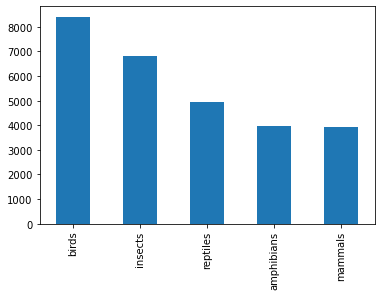

In [18]:
species.group.value_counts().plot(kind='bar')

<AxesSubplot:>

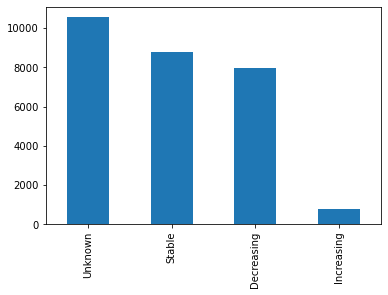

In [19]:
species.trend.value_counts().plot(kind='bar')

<AxesSubplot:>

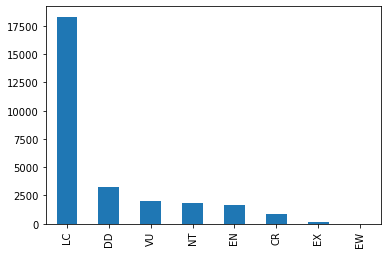

In [20]:
species.threat_level.value_counts().plot(kind='bar')

# Create data for species per trend per country

In [21]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot_table(index='country', columns='trend', values='count')
species_trend_country = species_trend_country.fillna(0.0)
species_trend_country['Total'] = species_trend_country.sum(axis=1)
species_trend_country.shape

(65, 5)

In [22]:
species_trend_country.head()

trend,Decreasing,Increasing,Stable,Unknown,Total
country,,,,,
Argentina,594,94,857,618,2163
Armenia,184,70,162,97,513
Australia,559,84,1166,1049,2858
Austria,256,81,221,190,748
Azerbaijan,207,75,191,113,586


## Create data for species per threat level per country

In [23]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl_country = grouped.pivot_table(index='country', columns='threat_level', values='count')
species_tl_country = species_tl_country.fillna(0.0)
species_tl_country['Total'] = species_tl_country.sum(axis=1)
species_tl_country.shape

(65, 9)

In [24]:
species_tl_country.head()

threat_level,CR,DD,EN,EW,EX,LC,NT,VU,Total
country,,,,,,,,,
Argentina,26.0,114.0,57.0,0.0,3.0,1759.0,116.0,88.0,2163.0
Armenia,6.0,13.0,6.0,0.0,0.0,428.0,37.0,23.0,513.0
Australia,57.0,142.0,106.0,0.0,36.0,2211.0,149.0,157.0,2858.0
Austria,3.0,47.0,11.0,0.0,0.0,590.0,64.0,33.0,748.0
Azerbaijan,5.0,13.0,6.0,0.0,0.0,496.0,39.0,27.0,586.0


This DataFrames include the same data as the "Table 6a" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.

## Create data for species per class per country

In [25]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'group'])['scientific_name'].count().reset_index(name='count')
species_group_country = grouped.pivot_table(index='country', columns='group', values='count')
species_group_country = species_group_country.fillna(0.0)
species_group_country['Total'] = species_group_country.sum(axis=1)
species_group_country.shape

(65, 6)

In [26]:
species_group_country.head()

group,amphibians,birds,insects,mammals,reptiles,Total
country,,,,,,
Argentina,165.0,1001.0,242.0,379.0,376.0,2163.0
Armenia,8.0,297.0,73.0,92.0,43.0,513.0
Australia,223.0,726.0,563.0,354.0,992.0,2858.0
Austria,19.0,305.0,323.0,88.0,13.0,748.0
Azerbaijan,11.0,348.0,73.0,104.0,50.0,586.0


This DataFrames include the same data as the "Table 5" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.

## Evaluate reason for missing trends

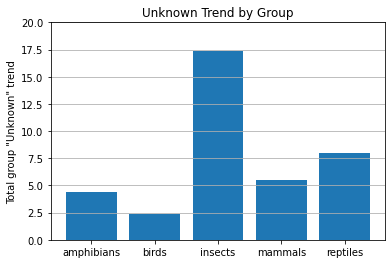

In [211]:
miss_trend = species[species.trend == 'Unknown'].sort_values('group')

miss_trend_group = miss_trend.drop(['threat_level'], axis=1)

miss_trend_group = miss_trend_group.groupby(['trend', 'group']).count().scientific_name
total_group = species.sort_values('group').groupby(['group']).count().scientific_name

plt.bar(species.sort_values('group').group.unique(), miss_trend_group / sum(total_group) * 100)
plt.title('Unknown Trend by Group')
plt.ylabel('Total group "Unknown" trend')
plt.ylim(0,20)
plt.grid(axis='y')
plt.show()

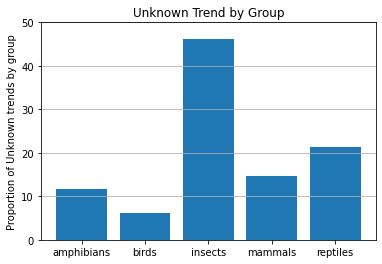

In [214]:
plt.bar(species.sort_values('group').group.unique(), miss_trend_group / sum(miss_trend_group) * 100)
plt.title('Unknown Trend by Group')
plt.ylabel('Proportion of Unknown trends by group')
plt.ylim(0,50)
plt.grid(axis='y')
plt.show()

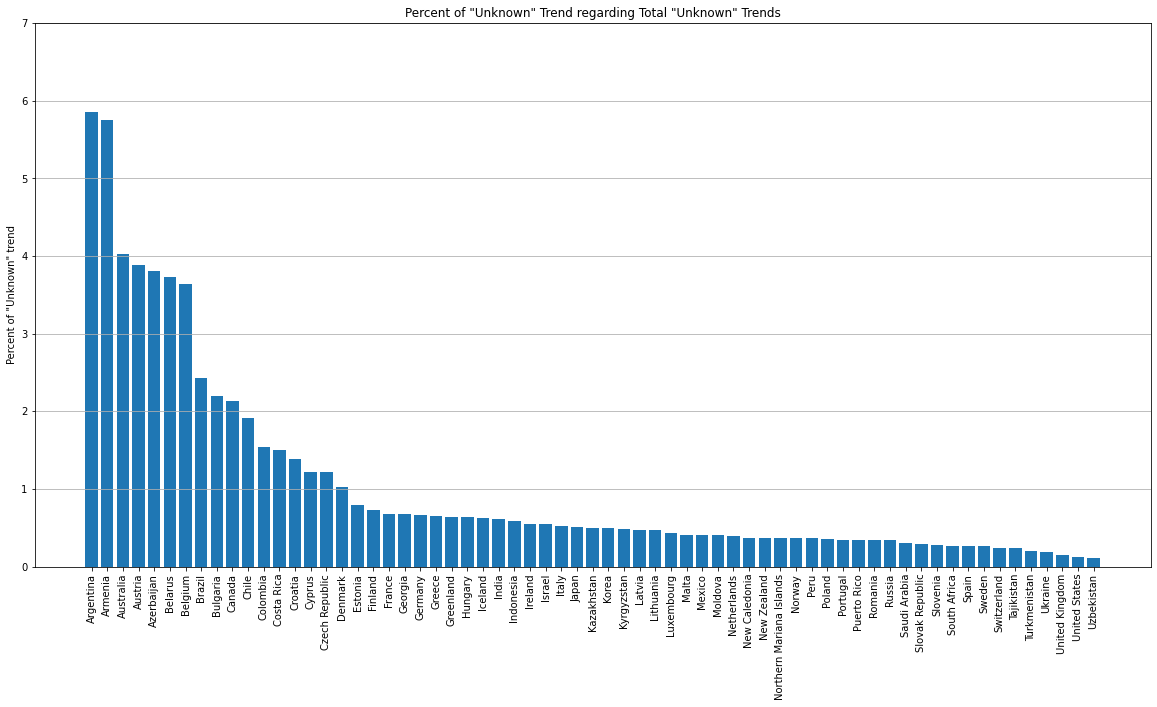

In [216]:
miss_trend_country = species_trend_country.copy()
miss_trend_country['Percent_Unknown'] = miss_trend_country.Unknown / sum(total_group) * 100
miss_trend_country['Proportion_Unknown'] = miss_trend_country.Unknown / miss_trend_country.Total * 100

plt.figure(figsize=(20,10))
plt.bar(miss_trend_country.reset_index()['country'], 
        miss_trend_country.sort_values('Percent_Unknown', ascending=False)['Percent_Unknown']
    )
plt.title('Percent of "Unknown" Trend regarding Total "Unknown" Trends')
plt.ylabel('Percent of "Unknown" trend')
plt.xticks(rotation='vertical')
plt.ylim(0,7)
plt.grid(axis='y')
plt.show()

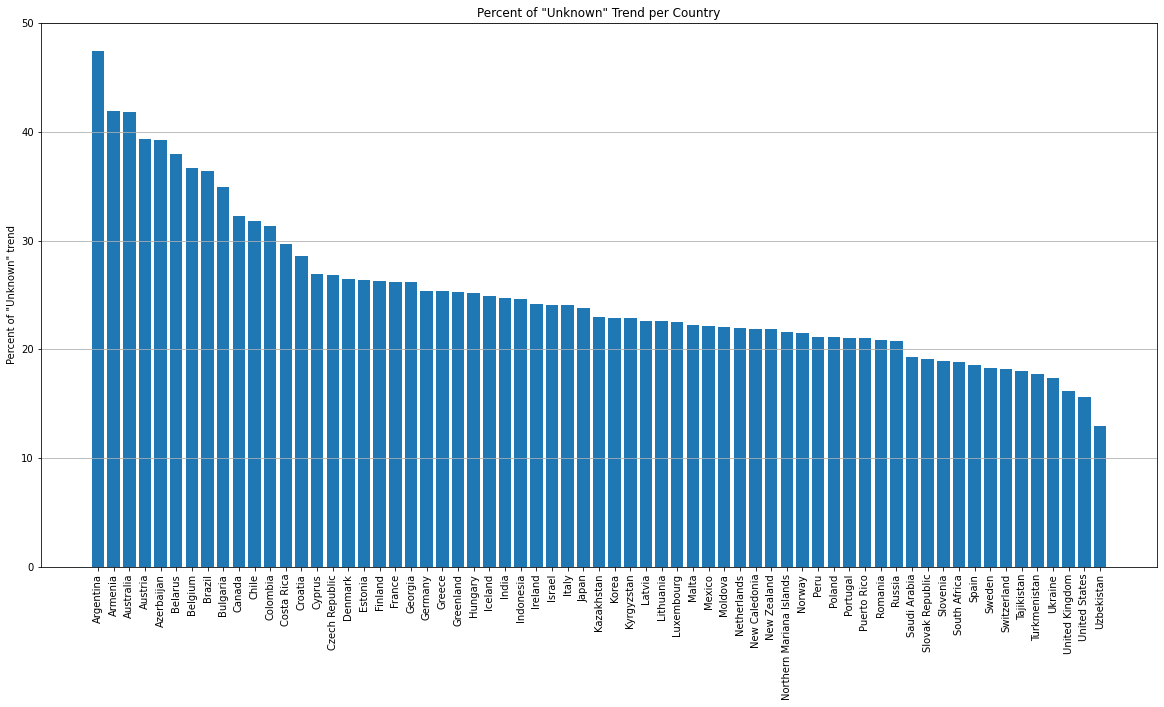

In [217]:
plt.figure(figsize=(20,10))
plt.bar(miss_trend_country.reset_index()['country'], 
        miss_trend_country.sort_values('Proportion_Unknown', ascending=False)['Proportion_Unknown']
    )
plt.title('Percent of "Unknown" Trend per Country')
plt.xticks(rotation='vertical')
plt.ylim(0,50)
plt.ylabel('Percent of "Unknown" trend')
plt.grid(axis='y')
plt.show()

In [200]:
miss_trend_country

trend,Decreasing,Increasing,Stable,Unknown,Total,Percent_Unknown,Proportion_Unknown
country,,,,,,,
Argentina,594,94,857,618,2163,2.200855,28.571429
Armenia,184,70,162,97,513,0.345442,18.908382
Australia,559,84,1166,1049,2858,3.735755,36.703989
Austria,256,81,221,190,748,0.676638,25.401070
Azerbaijan,207,75,191,113,586,0.402422,19.283276
...,...,...,...,...,...,...,...
Turkmenistan,186,66,199,132,583,0.470085,22.641509
Ukraine,254,82,193,180,709,0.641026,25.387870
United Kingdom,152,68,135,97,452,0.345442,21.460177


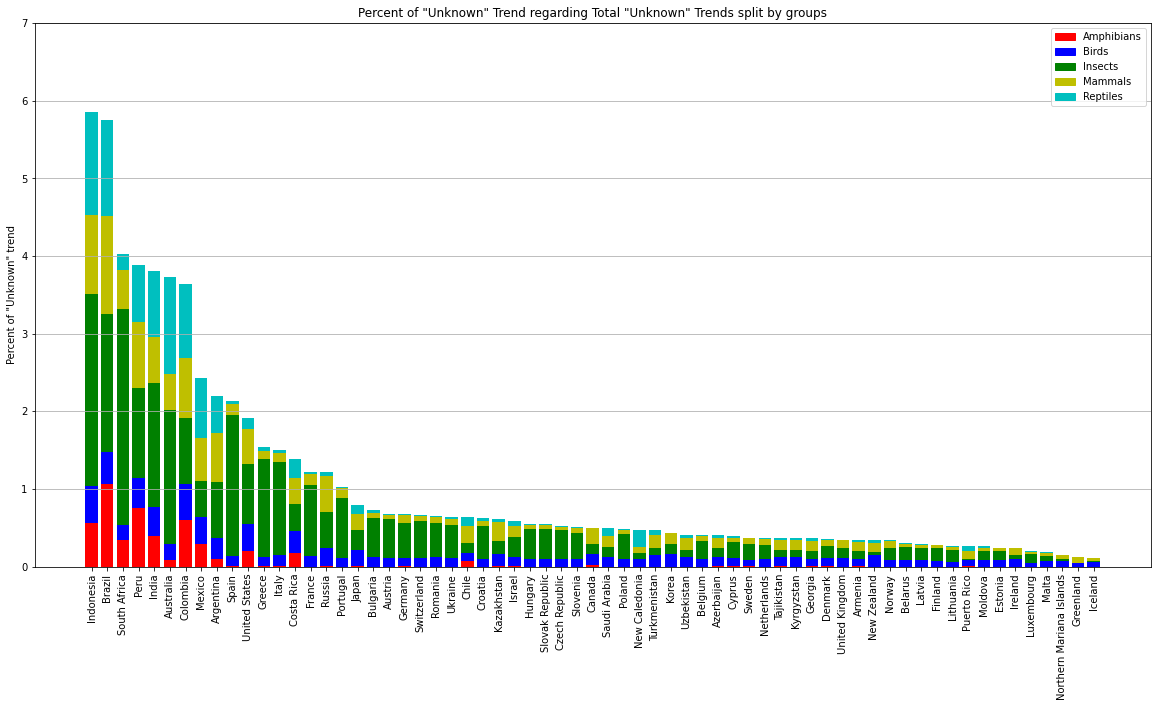

In [198]:
miss_trend_country_group = IUCN_cleaned_data[IUCN_cleaned_data.trend=='Unknown'].groupby(['country', 'group'])['scientific_name'].count().reset_index(name='count')

miss_trend_country_group = miss_trend_country_group.set_index('country')

ind = miss_trend_country.drop(['Decreasing', 'Increasing', 'Stable'], axis=1).sort_values('Percent_Unknown', ascending=False)

miss_tcg_amphibians = miss_trend_country_group[miss_trend_country_group.group == 'amphibians']
miss_tcg_birds = miss_trend_country_group[miss_trend_country_group.group == 'birds']
miss_tcg_insects = miss_trend_country_group[miss_trend_country_group.group == 'insects']
miss_tcg_mammals = miss_trend_country_group[miss_trend_country_group.group == 'mammals']
miss_tcg_reptiles = miss_trend_country_group[miss_trend_country_group.group == 'reptiles']

miss_tcg_amphibians = pd.concat([ind, miss_tcg_amphibians], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_birds = pd.concat([ind, miss_tcg_birds], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_insects = pd.concat([ind, miss_tcg_insects], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_mammals = pd.concat([ind, miss_tcg_mammals], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_reptiles = pd.concat([ind, miss_tcg_reptiles], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)

miss_tcg_amphibians['Percent_Unknown'] = miss_tcg_amphibians['count'] / sum(total_group) * 100
miss_tcg_birds['Percent_Unknown'] = miss_tcg_birds['count'] / sum(total_group) * 100
miss_tcg_insects['Percent_Unknown'] = miss_tcg_insects['count'] / sum(total_group) * 100
miss_tcg_mammals['Percent_Unknown'] = miss_tcg_mammals['count'] / sum(total_group) * 100
miss_tcg_reptiles['Percent_Unknown'] = miss_tcg_reptiles['count'] / sum(total_group) * 100

countries = ind.reset_index()['country']

amphibians = miss_tcg_amphibians['Percent_Unknown'].values
birds = miss_tcg_birds['Percent_Unknown'].values
insects = miss_tcg_insects['Percent_Unknown'].values
mammals = miss_tcg_mammals['Percent_Unknown'].values
reptiles = miss_tcg_reptiles['Percent_Unknown'].values

plt.figure(figsize=(20,10))
plt.bar(countries, amphibians, color='r')
plt.bar(countries, birds, bottom=amphibians, color='b')
plt.bar(countries, insects, bottom=birds + amphibians, color='g')
plt.bar(countries, mammals, bottom=insects + birds + amphibians, color='y')
plt.bar(countries, reptiles, bottom=mammals + insects + birds + amphibians, color='c')

plt.title('Percent of "Unknown" Trend regarding Total "Unknown" Trends split by groups')
plt.xticks(rotation='vertical')
plt.ylim(0,7)
plt.ylabel('Percent of "Unknown" trend')

colors = {'Amphibians':'r', 'Birds':'b', 'Insects':'g', 'Mammals':'y', 'Reptiles':'c'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.grid(axis='y')

plt.show()

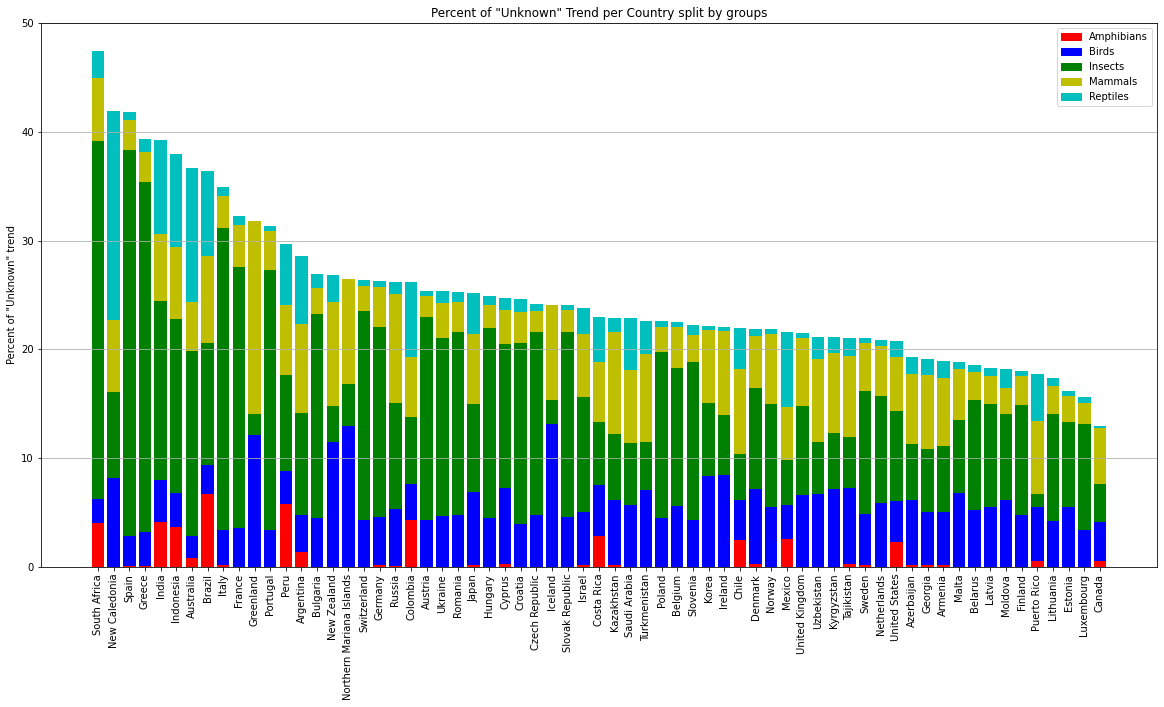

In [199]:
miss_trend_country_group = IUCN_cleaned_data[IUCN_cleaned_data.trend=='Unknown'].groupby(['country', 'group'])['scientific_name'].count().reset_index(name='count')

miss_trend_country_group = miss_trend_country_group.set_index('country')

ind = miss_trend_country.drop(['Decreasing', 'Increasing', 'Stable'], axis=1).sort_values('Proportion_Unknown', ascending=False)

miss_tcg_amphibians = miss_trend_country_group[miss_trend_country_group.group == 'amphibians']
miss_tcg_birds = miss_trend_country_group[miss_trend_country_group.group == 'birds']
miss_tcg_insects = miss_trend_country_group[miss_trend_country_group.group == 'insects']
miss_tcg_mammals = miss_trend_country_group[miss_trend_country_group.group == 'mammals']
miss_tcg_reptiles = miss_trend_country_group[miss_trend_country_group.group == 'reptiles']

miss_tcg_amphibians = pd.concat([ind, miss_tcg_amphibians], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_birds = pd.concat([ind, miss_tcg_birds], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_insects = pd.concat([ind, miss_tcg_insects], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_mammals = pd.concat([ind, miss_tcg_mammals], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_reptiles = pd.concat([ind, miss_tcg_reptiles], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)

miss_tcg_amphibians['Proportion_Unknown'] = miss_tcg_amphibians['count'] / miss_tcg_amphibians.Total * 100
miss_tcg_birds['Proportion_Unknown'] = miss_tcg_birds['count'] / miss_tcg_birds.Total * 100
miss_tcg_insects['Proportion_Unknown'] = miss_tcg_insects['count'] / miss_tcg_insects.Total * 100
miss_tcg_mammals['Proportion_Unknown'] = miss_tcg_mammals['count'] / miss_tcg_mammals.Total * 100
miss_tcg_reptiles['Proportion_Unknown'] = miss_tcg_reptiles['count'] / miss_tcg_reptiles.Total * 100

countries = ind.reset_index()['country']

amphibians = miss_tcg_amphibians['Proportion_Unknown'].values
birds = miss_tcg_birds['Proportion_Unknown'].values
insects = miss_tcg_insects['Proportion_Unknown'].values
mammals = miss_tcg_mammals['Proportion_Unknown'].values
reptiles = miss_tcg_reptiles['Proportion_Unknown'].values

plt.figure(figsize=(20,10))
plt.bar(countries, amphibians, color='r')
plt.bar(countries, birds, bottom=amphibians, color='b')
plt.bar(countries, insects, bottom=birds + amphibians, color='g')
plt.bar(countries, mammals, bottom=insects + birds + amphibians, color='y')
plt.bar(countries, reptiles, bottom=mammals + insects + birds + amphibians, color='c')

plt.title('Percent of "Unknown" Trend per Country split by groups')
plt.xticks(rotation='vertical')
plt.ylim(0,50)
plt.ylabel('Percent of "Unknown" trend')

colors = {'Amphibians':'r', 'Birds':'b', 'Insects':'g', 'Mammals':'y', 'Reptiles':'c'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.-

plt.show()

## Write species data to csv

In [32]:
species_group_country.to_csv('./data/IUCN/species_per_country.csv')